In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# @markdown Loading Dependencies
%%capture installation
!pip install pyrebase
!pip install patool
!pip install pgeocode

from datetime import datetime
import math
from bs4 import BeautifulSoup as bs
import requests
import pgeocode
import json
import patoolib
from distutils.dir_util import copy_tree
import os
import cv2
import decimal
import numpy as np
import pandas as pd
from keras.preprocessing.image import save_img 
from PIL import Image


In [ ]:
import pyrebase
import warnings
warnings.filterwarnings('ignore')

patoolib.extract_archive("/content/gdrive/My Drive/nerve.rar", outdir="/content")
src = '/content/nerve/nerve/model'
dst = '/content/model'
copy_tree(src, dst)
from model.u_net import get_unet_256


In [ ]:
# @markdown Meta-Data
#add details according to your account on firebase
%%file configshare.json
{
  
}
our_numbers = []

Writing configshare.json


In [ ]:
# @markdown Connecting with Firebase

number = our_numbers[9]
class Firebase:
    def __init__(self,configFilePath):
        '''
            Please allow read and write privilege to all 
        '''
        config_data = open(configFilePath,"r")
        config = json.load(config_data)
        self.firebase = pyrebase.initialize_app(config)
        self.db =  self.firebase.database()
        self.storage = self.firebase.storage()
    def downloadLatestImage(self):
        self.img_from_fb = []
        images = [image.val() for image in self.db.child(number).child('uploadedFromPython').get().each()]
        #print(images[len(images)-1])
        for i in range(self.getCount()):
          img_name = str(images[len(images)-1-i])
          self.img_from_fb.append(img_name)
          self.downloadImageFromFireBase('uploadedFromPython/'+img_name,img_name)
    def downloadImageFromFireBase(self,path,saveName):
        '''
            folder fetches image from url
            and saves as downloads.jpeg
            path example: images/one.jpeg
        '''
        self.storage.child(number).child(path).download(saveName)
    def uploadImageFromFireBase(self,imagePath,imageName):
        '''
            imagePath is the path of image to be uploaded
            imageName is the name reflected on firebase in uploadedFromPython
        '''
        uploadPath = 'segmentedImages/'+imageName
        self.storage.child(number).child(uploadPath).put(imagePath)
        self.db.child(number).child('segmentedImages').push(imageName)
    def getLat(self):
        #lat =[lat.val() for lat in self.db.child(our_numbers[1]).child('uploadedLat').get().each()]
        lat = self.db.child(number).child('uploadedLat').get()
        self.latitude = lat.val()
        return self.latitude
    def getLon(self):
        #lon =[lon.val() for lon in self.db.child(our_numbers[1]).child('uploadedLon').get().each()]
        lon = self.db.child(number).child('uploadedLon').get()
        self.longitude = lon.val()
        return self.longitude
    def getArea(self):
        areaOfRooftop = self.db.child(number).child('uploadedArea').get()
        self.area = areaOfRooftop.val()
        return self.area
    def getCount(self):
        flag = self.db.child(number).child('uploadedCount').get()
        self.count = flag.val()
        return self.count
    def getPostalCode(self):
        postalCode = self.db.child(number).child('uploadedPostalCode').get()
        self.postal = postalCode.val()
        return self.postal
    def saveResultToDatabase(self,result):
        self.db.child(number).child('result').push(result)
obj  = Firebase("configshare.json")
obj.downloadLatestImage()

In [ ]:
print('Latitude of user : {} '.format(obj.getLat()))
print('Longitude of user : {} '.format(obj.getLon()))
print("Area of user's rooftop/balcony : {} ".format(obj.getArea()))
print('Pincode of user : {} '.format(obj.getPostalCode()))

Latitude of user : 26.9421014 
Longitude of user : 75.7744624 
Area of user's rooftop/balcony : 150 
Pincode of user : 302039 


In [ ]:
obj.img_from_fb

['IMG_1590143170678.png',
 'IMG_1590143170638.png',
 'IMG_1590143170595.png',
 'IMG_1590143170537.png']

In [ ]:
# @markdown IMAGE SEGMENTATION
model = get_unet_256()
data_dir = '/content'
input_size = 256 
epochs = 5
batch_size = 16

orig_width = 580
orig_height = 420

threshold = 0.5
rles = []
model.load_weights('/content/gdrive/My Drive/minor/segmentation_weights2.h5')
x_batch=[]

#img_from_fb = ['2.png','3.png','5.png','6.png']

def run_length_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.transpose().flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

for i in obj.img_from_fb:
  img_path = '/content/' + i
  #img_path = '/content/' + i
  img = cv2.imread(img_path)
  img = cv2.resize(img, (input_size, input_size))
  x_batch.append(img)

x_batch = np.array(x_batch, np.float32) / 255
preds = model.predict(x_batch)
preds = np.squeeze(preds, axis=3)

for pred in preds:
  prob = cv2.resize(pred, (orig_width, orig_height))
  mask = prob > threshold
  rle = run_length_encode(mask)
  rles.append(rle)
#prob = cv2.resize(preds[0], (orig_width, orig_height))
#mask = prob > threshold
#rle = run_length_encode(mask)

def rle_decode(mask_rle, shape=(orig_width,orig_height)):
    #print('rle_decode(mask_rle = ', mask_rle)
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

mylist = img_path.split('/')
mylist.pop()
file_path = '/'.join(mylist)
masks_path = []
for k in range(len(rles)):
  imgg= rle_decode(rles[k])
  output = 'mask_' + obj.img_from_fb[k]
  #output = 'mask_' + img_from_fb[k]
  out_path = os.path.join(file_path, output)
  masks_path.append(out_path)
  save_img(out_path, imgg[..., np.newaxis])
  print('Image Saved Succesfully at {} location with image name : {}'.format(file_path,output))
  obj.uploadImageFromFireBase(out_path,output)


Image Saved Succesfully at /content location with image name : mask_IMG_1590143170678.png
Image Saved Succesfully at /content location with image name : mask_IMG_1590143170638.png
Image Saved Succesfully at /content location with image name : mask_IMG_1590143170595.png
Image Saved Succesfully at /content location with image name : mask_IMG_1590143170537.png


In [ ]:
# @markdown Distance Calculator 
def calculateDist(lati1,long1,lati2,long2):
  R = 6373.00

  lat1 = math.radians(round(float(lati1),2))
  lon1 = math.radians(round(float(long1),2))
  lat2 = math.radians(lati2)
  lon2 = math.radians(long2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
  distance = R * c
#distance is in km
  #print(distance)
  return distance

In [ ]:
# @markdown Calculations of Solar Potential, Temperature and Energy

#list_im = ['1.jpg', '2.jpg', '3.jpg','4.jpg']
imgs    = [ Image.open(i) for i in masks_path ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

# save that beautiful picture
imgs_comb = Image.fromarray( imgs_comb)
imgs_comb.save( 'sky_horizontal.jpg' )    

#calculating fraction
#img = cv2.imread(output, 0)
img = cv2.imread('sky_horizontal.jpg', 0)
c = 0
x, y = img.shape
for i in range(0,x):
  for j in range(0,y):
    if img[i][j] != 0:
      c = c+1
rounded = round(c/(x*y), 1)
print('Fraction of sky/sunlight exposed : {} '.format(rounded))

#calculating state name
nomi = pgeocode.Nominatim('in')
var = nomi.query_postal_code(obj.getPostalCode())
#var = nomi.query_postal_code('412207')
state_name = var.state_name
try:
  stateName = state_name.lower()
except:
  pass
print("State name: {}".format(stateName))
stateName= stateName.split(' ')[0]
#print(stateName)
#calculating current month 
currentMonth = datetime.now().month
print('Current month in numerical value is {}'.format(currentMonth))
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

df = pd.read_csv('/content/gdrive/My Drive/minor/Irradiance_Dataset2.csv')
stateName_index = []
for i in df.index:
  if df['State'][i].startswith(stateName):
    stateName_index.append(i)
#print(stateName_index)
df = df.take(stateName_index)
df2 = df[df['Month']==months[currentMonth-1]]
distances = []

#calculation of irradiance values
for i in df2.index:
  distances.append(calculateDist(obj.getLat(),obj.getLon(),df2['Latitude'][i],df2['Longitude'][i]))

index = df2.index[distances.index(min(distances))]
closestDistrict = df2['District'][index]
irradianceVal = df2['Irradiance'][index]
temperature = df2['Temperature'][index]
irrData =df[df['District']==closestDistrict]
print("Closest District : {}".format(closestDistrict))

#formula for calculating solar potential in kWh per square meter per day
#solarPotential = irradianceVal * float(obj.getArea()) * rounded 

#formula for calculating Energy in Joules per square meter
#energy = solarPotential * 3600 * 1000

#Since,Crops / plants absorb about 2% of solar energy falled on them
#energyPlants = energy * 0.02
irr = list(irrData['Irradiance'])
factor = float(obj.getArea()) * rounded * 3600 * 1000 * 0.02
energyPlants = list(map(lambda x: round(x*factor) , irr)) 
print('Energy of plants (month-wise): {} '.format(energyPlants))

Fraction of sky/sunlight exposed : 0.4 
State name: rajasthan
Current month in numerical value is 5
Closest District : Jaipur
Energy of plants (month-wise): [18230400, 22593600, 27043200, 30326400, 32097600, 28555200, 25531200, 23198400, 25747200, 23976000, 19872000, 17193600] 


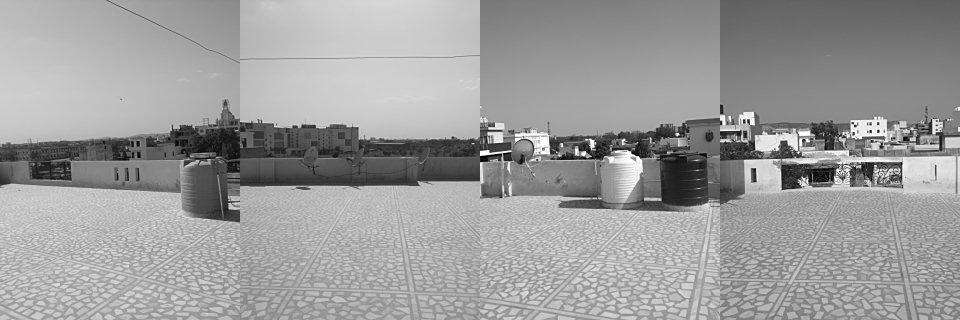

In [ ]:
from google.colab.patches import cv2_imshow
imgs    = [ Image.open(i) for i in obj.img_from_fb ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb_original = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

# save that beautiful picture
imgs_comb_original = Image.fromarray( imgs_comb_original)
imgs_comb_original.save( 'sky_horizontal_original.jpg' )    
all_img = cv2.imread('sky_horizontal_original.jpg' , 0)
  #all_img = cv2.resize(all_img, (256, 256))
cv2_imshow(all_img)


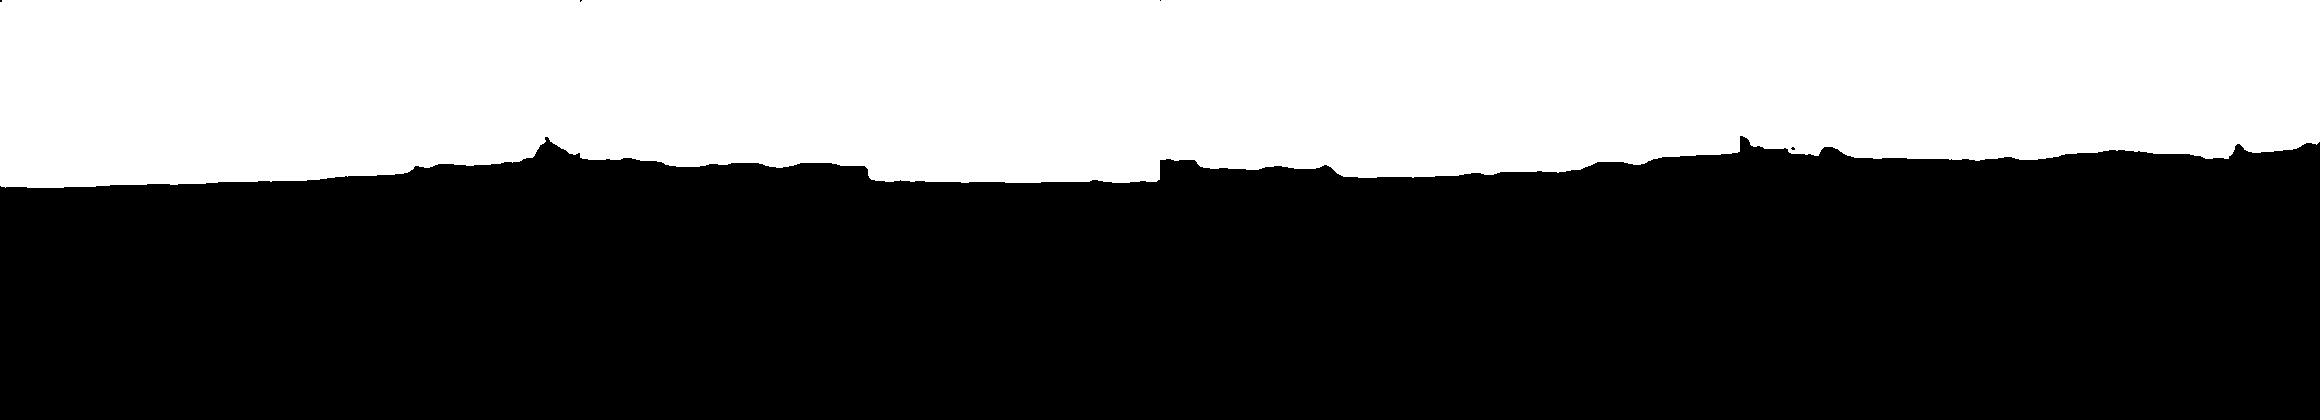

In [ ]:
cv2_imshow(img)

In [ ]:
irrData

,Unnamed: 0,State,District,Latitude,Longitude,Month,Irradiance,Temperature
528,528,rajasthan,Jaipur,26.95,75.75,jan,4.22,16
529,529,rajasthan,Jaipur,26.95,75.75,feb,5.23,20
530,530,rajasthan,Jaipur,26.95,75.75,mar,6.26,25
531,531,rajasthan,Jaipur,26.95,75.75,apr,7.02,31
532,532,rajasthan,Jaipur,26.95,75.75,may,7.43,34
533,533,rajasthan,Jaipur,26.95,75.75,jun,6.61,34
534,534,rajasthan,Jaipur,26.95,75.75,jul,5.91,31
535,535,rajasthan,Jaipur,26.95,75.75,aug,5.37,29
536,536,rajasthan,Jaipur,26.95,75.75,sep,5.96,29
537,537,rajasthan,Jaipur,26.95,75.75,oct,5.55,28


In [ ]:
# @markdown Preprocessing of Plant Dataset
plantsData = pd.read_excel('/content/gdrive/My Drive/minor/plants dataset.xlsx')
startingMonth = []
endingMonth = []
for i in plantsData.index:
  monthRange = plantsData['months'][i].split(" - ")
  startingMonth.append(monthRange[0].lower())
  endingMonth.append(monthRange[1].lower())
plantsData.insert(6, "Starting Month", startingMonth, True) 
plantsData.insert(7, "Ending Month", endingMonth, True) 
plantsData.head(29)


,plants,soil,min temp,max temp,energy/ sq. m in Joules,weather,Starting Month,Ending Month,months,image
0,Tomato,Loam and Sandy Loam,18,24,409680,Warm / Summer,mar,jun,Mar - Jun,https://www.growjoy.com/store/pc/catalog/manal...
1,Spinach,Loam,10,22,417600,All,sep,jun,Sep - Jun,https://hips.hearstapps.com/hmg-prod.s3.amazon...
2,Radish,Fertile Drained Sandy,10,30,360000,Winter / Spring,mar,oct,Mar - Oct,https://189662-567937-2-raikfcquaxqncofqfm.sta...
3,Cucumber,Loam and Sandy Loam,18,24,374400,Early Summer,mar,aug,Mar - Aug,https://upload.wikimedia.org/wikipedia/commons...
4,Sweet Potato,Loam and Sandy Loam,20,35,385200,All,jun,sep,Jun - Sep,https://cdn.freshplaza.com/2018/0315/SPotato_P...
5,Curry Leaves,Well Drained Sandy,20,35,421200,Summer,mar,aug,Mar - Aug,https://images-na.ssl-images-amazon.com/images...
6,Lemon ( Dwarf ),Loam and Sandy Loam,10,40,405360,All,jul,dec,Jul - Dec,https://images-na.ssl-images-amazon.com/images...
7,Brinjal,Silt Loam,13,21,403200,All,jul,jun,Jul - Jun,https://189662-567937-2-raikfcquaxqncofqfm.sta...
8,Coriander,Silt Loam,20,25,406800,Late Spring and Autumn,mar,sep,Mar - Sep,https://gardenerspath.com/wp-content/uploads/2...
9,Mint,Moist and Well Drained,13,21,374400,All,mar,jun,Mar - Jun,https://www.growforagecookferment.com/wp-conte...


In [ ]:
# @markdown Function for filtering (Month & Temperature) 
def checkMonth(data,i,current,months):
  start = months.index(data['Starting Month'][i])
  end = months.index(data['Ending Month'][i])
  if start <= end:
    if current >= start and current <=end:
      return True
    else:
      return False
  else:
    if current >= end and current <=start:
      return False
    else:
      return True
def checkTemp(data,i,temp):
  if temp >= data['min temp'][i] and temp <= data['max temp'][i]:
    return True
  else:
    return False

In [ ]:
# @markdown Filter Plants that satisfies all necessary conditions
plantIndex = []
satisfiesTemp = set()
name=''
bestPlants = {}
bestPlantsName = {}

if rounded >= 0.3:
  for value in range(len(energyPlants)):
    plants = []
    plantsName = []
    satisfiesTemp = set()
    for ind in plantsData.index:
      if checkMonth(plantsData,ind,value,months) and checkTemp(plantsData,ind,irrData['Temperature'][irrData.index[0]+value]):
        satisfiesTemp.add(ind)
    #print(satisfiesTemp)
    for i in list(satisfiesTemp):
      energyCalculated = int(plantsData['energy/ sq. m in Joules'][i]) * float(obj.getArea())
      energyDiff = energyCalculated - int(energyPlants[value])
      #if energyDiff*100/energyCalculated < 50  and int(energyPlants[value]) <= energyCalculated:
      if int(energyPlants[value]) <= energyCalculated:
        plants.append(str(i))
        plantsName.append(plantsData['plants'][i])
    #print(plants)
    bestPlants[months[value]] = plants
    bestPlantsName[months[value]] = plantsName

  for key,value in bestPlants.items():
    if value:
      string = '-'.join(value)
      name = name + '::' + key + ';' + string
else:
  name = "NULL"

obj.saveResultToDatabase(name)
print('Best Plants : {} '.format(bestPlantsName))
print('Result sent to Database : {} '.format(name))

Best Plants : {'jan': ['Spinach', 'Brinjal', 'Betel Leaves', 'Cabbage', 'Carrot', 'Turnip', 'Cauliflower', 'Peas'], 'feb': ['Spinach', 'Brinjal', 'Okra', 'Turnip', 'Cauliflower', 'Peas', 'Tuberose', 'Rose'], 'mar': ['Radish', 'Curry Leaves', 'Coriander', 'Okra', 'Beans', 'Peas', 'Rose'], 'apr': ['Curry Leaves'], 'may': ['Curry Leaves'], 'jun': ['Sweet Potato', 'Curry Leaves'], 'jul': ['Tuberose', 'Sweet Potato', 'Curry Leaves', 'Lemon ( Dwarf )'], 'aug': ['Radish', 'Sweet Potato', 'Curry Leaves', 'Lemon ( Dwarf )', 'Okra', 'Beetroot', 'Tuberose'], 'sep': ['Radish', 'Sweet Potato', 'Lemon ( Dwarf )', 'Beetroot', 'Tuberose'], 'oct': ['Radish', 'Lemon ( Dwarf )', 'Beetroot', 'Tuberose', 'Rose', 'Marigold'], 'nov': ['Spinach', 'Lemon ( Dwarf )', 'Betel Leaves', 'Cabbage', 'Carrot', 'Turnip', 'Tuberose', 'Marigold'], 'dec': ['Spinach', 'Lemon ( Dwarf )', 'Brinjal', 'Betel Leaves', 'Cabbage', 'Carrot', 'Turnip', 'Cauliflower', 'Tuberose', 'Marigold']} 
Result sent to Database : ::jan;1-7-10-

# **DO NOT RUN CODE AFTER THIS**
This code is for *collage*

In [ ]:
# @markdown Filter Plants that satisfies all necessary conditions
plantIndex = []
satisfiesTemp = set()
name=''
bestPlants = {}
bestPlantsName = {}

if rounded >= 0.3:
  for value in range(len(energyPlants)):
    plants = []
    plantsName = []
    satisfiesEnergy = set()
    for i in plantsData.index:
      energyCalculated = int(plantsData['energy/ sq. m in Joules'][i]) * float(obj.getArea())
      energyDiff = energyCalculated - int(energyPlants[value])
      if energyDiff*100/energyCalculated < 50  and int(energyPlants[value]) <= energyCalculated:
        print(satisfiesEnergy)
        satisfiesEnergy.add(i)
    for ind in list(satisfiesEnergy):
      if irrData['Temperature'][irrData.index[0] + value]>= plantsData['min temp'][ind] and irrData['Temperature'][irrData.index[0] + value] <= plantsData['max temp'][ind] and checkMonth(plantsData,ind,value,months):
        plants.append(ind)
      #print(plants)
        plantsName.append(plantsData['plants'][ind])
    bestPlants[months[value]] = plants
    bestPlantsName[months[value]] = plantsName
  #name = 
else:
  name = "NULL"

obj.saveResultToDatabase(name)
print('Best Plants : {} '.format(bestPlantsName))
print('Result sent to Database : {} '.format(name))

set()
{13}
{13, 14}
{13, 14, 22}
{23, 13, 14, 22}
{13, 14, 22, 23, 24}
{13, 14, 22, 23, 24, 25}
{13, 14, 22, 23, 24, 25, 26}
{13, 14, 22, 23, 24, 25, 26, 27}
{13, 14, 22, 23, 24, 25, 26, 27, 28}
set()
{2}
{2, 3}
{9, 2, 3}
{11, 9, 2, 3}
{2, 3, 9, 11, 14}
{2, 3, 9, 11, 14, 17}
{2, 3, 9, 11, 14, 17, 19}
{2, 3, 9, 11, 14, 17, 19, 20}
{2, 3, 9, 11, 14, 17, 19, 20, 22}
{2, 3, 9, 11, 14, 17, 19, 20, 22, 23}
{2, 3, 9, 11, 14, 17, 19, 20, 22, 23, 26}
{2, 3, 9, 11, 14, 17, 19, 20, 22, 23, 26, 27}
{2, 3, 9, 11, 14, 17, 19, 20, 22, 23, 26, 27, 28}
set()
{0}
{0, 1}
{0, 1, 2}
{0, 1, 2, 3}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17}
{0, 1, 

In [ ]:
obj.saveResultToDatabase(name)


In [ ]:
name

'::jan;::feb;24-25::mar;1-2-5-7-8-10-11-12-15-16-19-20-21::apr;1-2-5-7-8-10-11-12-15-16-19-20-21::may;1-2-5-7-8-10-11-12-15-16-19-20-21::jun;2-4-7-8-11-12-15-19-20-21::jul;24-25::aug;2-11-25::sep;2-11-24-25::oct;11-24-25-27::nov;24-25-27::dec;24-25-27'

In [ ]:
# @markdown Filter Plants that satisfies all necessary conditions
plantIndex = []
satisfiesTemp = set()
satisfiesEnergy = set()
plantsDistrict = df[df['District']==closestDistrict]
name=''
bestPlants = {}
bestPlantsName = {}
plants = []
plantsName = []
if rounded >= 0.3:
  for i in plantsData.index:
    energyCalculated = int(plantsData['energy/ sq. m in Joules'][i]) * float(obj.getArea())
    energyDiff = energyCalculated - int(energyPlants)
    if energyDiff*100/energyCalculated < 50  and int(energyPlants) <= energyCalculated:
      satisfiesEnergy.add(i)
  for ind in list(satisfiesEnergy):
    if temperature >= plantsData['min temp'][ind] and temperature <= plantsData['max temp'][ind] and checkMonth(plantsData,ind,currentMonth-1,months):
      plants.append(ind)
      #print(plants)
      plantsName.append(plantsData['plants'][ind])
  bestPlants[months[currentMonth-1]] = plants
  bestPlantsName[months[currentMonth-1]] = plantsName
  name = 
else:
  name = "NULL"

obj.saveResultToDatabase(name)
print('Best Plants : {} '.format(bestPlantsName))
print('Result sent to Database : {} '.format(name))

Best Plants : {'may': ['Curry Leaves']} 
Result sent to Database : ::may;Sweet Potato-Curry Leaves-Lemon ( Dwarf )-Betel Leaves::jan;Spinach-Radish-Lemon ( Dwarf )-Brinjal-Mint-Betel Leaves-Cabbage-Carrot-Beetroot-Turnip-Cauliflower-Peas::feb;Tomato-Spinach-Radish-Cucumber-Sweet Potato-Curry Leaves-Lemon ( Dwarf )-Brinjal-Coriander-Mint-Betel Leaves-Cabbage-Carrot-Okra-Beetroot-Chilli-Turnip-Cauliflower-Peas::mar;Radish-Sweet Potato-Curry Leaves-Lemon ( Dwarf )-Coriander-Betel Leaves-Cabbage-Okra-Beans-Beetroot-Chilli-Peas::apr;Radish-Sweet Potato-Curry Leaves-Lemon ( Dwarf )-Betel Leaves-Okra-Beans-Beetroot::jun;Sweet Potato-Curry Leaves-Lemon ( Dwarf )-Betel Leaves::jul;Radish-Sweet Potato-Curry Leaves-Lemon ( Dwarf )-Betel Leaves-Okra-Beans-Beetroot::aug;Radish-Sweet Potato-Curry Leaves-Lemon ( Dwarf )-Betel Leaves-Okra-Beans-Beetroot::sep;Radish-Sweet Potato-Curry Leaves-Lemon ( Dwarf )-Betel Leaves-Okra-Beans-Beetroot::oct;Radish-Sweet Potato-Curry Leaves-Lemon ( Dwarf )-Betel Lea

In [ ]:
# @markdown IMAGE SEGMENTATION


model = get_unet_256()
data_dir = '/content'
input_size = 256
epochs = 5
batch_size = 16

orig_width = 580
orig_height = 420

threshold = 0.5

model.load_weights('/content/gdrive/My Drive/minor/segmentation_weights2.h5')
x_batch=[]

def run_length_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.transpose().flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


img_path = '/content/' + obj.img_from_fb
img = cv2.imread(img_path)
img = cv2.resize(img, (input_size, input_size))
x_batch.append(img)
x_batch = np.array(x_batch, np.float32) / 255
preds = model.predict(x_batch)
preds = np.squeeze(preds, axis=3)
prob = cv2.resize(preds[0], (orig_width, orig_height))
mask = prob > threshold
rle = run_length_encode(mask)

def rle_decode(mask_rle, shape=(orig_width,orig_height)):
    #print('rle_decode(mask_rle = ', mask_rle)
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

imgg= rle_decode(rle)
mylist = img_path.split('/')
mylist.pop()
file_path = '/'.join(mylist)
output = 'mask' + obj.img_from_fb
out_path = os.path.join(file_path, output)
save_img(out_path, imgg[..., np.newaxis])
print('Image Saved Succesfully at {} location with image name : {}'.format(file_path,output))
obj.uploadImageFromFireBase(out_path,output)


Image Saved Succesfully at /content location with image name : maskIMG_20200518_133614.png
